In [1]:
#######################################################################
############         Exploratory Data Analysis            #############
############   Understanding the dataset to work with     #############
#######################################################################

# arXiv dataset and metadata of 1.7M+ scholarly papers across STEM
# https://www.kaggle.com/datasets/Cornell-University/arxiv
#
# ArXiv On Kaggle
# Metadata
# This dataset is a mirror of the original ArXiv data. Because the full dataset is rather large (1.1TB and growing), 
# this dataset provides only a metadata file in the json format. This file contains an entry for each paper, containing:
#
# id: ArXiv ID (can be used to access the paper, see below)
# submitter: Who submitted the paper
# authors: Authors of the paper
# title: Title of the paper
# comments: Additional info, such as number of pages and figures
# journal-ref: Information about the journal the paper was published in
# doi: [https://www.doi.org](Digital Object Identifier)
# abstract: The abstract of the paper
# categories: Categories / tags in the ArXiv system
# versions: A version history
#
# License
# Creative Commons CC0 1.0 Universal Public Domain Dedication applies to the metadata in this dataset. 
# See https://arxiv.org/help/license for further details and licensing on individual papers.

import logging
# Set the logging level to ERROR
logging.getLogger("dask").setLevel(logging.ERROR)

import shutil
import dask
import dask.dataframe as dd
from dask.distributed import Client
import dask.multiprocessing
from cluster_config import create_local_cluster

# EDA
import matplotlib.pyplot as plt

### Clean up previous run ###
# Specify the path to the dask-worker-space folder
dask_worker_space_path = "./dask-worker-space"
# Remove the folder if it exists
shutil.rmtree(dask_worker_space_path, ignore_errors=True)

# Create a local cluster with multiple processes
cluster = create_local_cluster()

# Connect a Dask client to the cluster
client = Client(cluster)

# Define data types for selected columns in a dictionary
dtypes = {
    'id': 'object',
    'submitter':'object',
    'authors':'object',
    'title':'object',
    'comments': 'object',
    'journal-ref': 'object',
    'doi': 'object',
    'report-no': 'object',
    'categories': 'object',
    'license': 'object',
    'abstract':'object',
    'versions':'object',
    'update_date':'datetime',
    'authors_parsed':'object',
}

df = dd.read_json(
    './arXiv/arxiv-metadata-oai-snapshot.json', 
    blocksize='8MB', 
    dtype=dtypes,
    )

df = df.repartition(npartitions=60)

In [2]:
# Inspecting what the dataframe looks like
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [3]:
# Number of entries per column
client.restart()
df.count().compute()

id                2322824
submitter         2307635
authors           2322824
title             2322824
comments          1770547
journal-ref        814762
doi               1141347
report-no          176908
categories        2322824
license           1869994
abstract          2322824
versions          2322824
update_date       2322824
authors_parsed    2322824
dtype: int64

In [4]:
# Number of Rows, Date range, Unique entries, top value_counts.
client.restart()
total_rows = len(df)
print('Total number of rows in dataset: ',total_rows)
print('')

client.restart()
min_date, max_date = dask.compute(
    df['update_date'].min(), df['update_date'].max()
)

print('Min date: ',min_date)
print('Max date: ',max_date)
print('')

client.restart()
authors_unique, title_unique, categories_unique = dask.compute(
    df['authors'].nunique(), 
    df['title'].nunique(),
    df['categories'].nunique())
print('Total of unique authors: ',authors_unique)
print('Total of unique titles: ',title_unique)
print('Total of unique categories: ',categories_unique)
print('')

client.restart()
authors_top_15 = dask.compute(
    df['authors'].value_counts().nlargest(15)
)

client.restart()
categories_top_25 = dask.compute(
    df['categories'].value_counts().nlargest(25)
)

print('The top 25 categories: \n',categories_top_25)
print('')
print('The top 15 authors: \n',authors_top_15)
print('')

Total number of rows in dataset:  2322824

Min date:  2007-05-23
Max date:  2023-09-08

Total of unique authors:  1795640
Total of unique titles:  2318866
Total of unique categories:  78758

The top 25 categories: 
 (astro-ph              86911
hep-ph                79614
quant-ph              65375
hep-th                57617
cs.CV                 48926
cond-mat.mtrl-sci     37302
cond-mat.mes-hall     33855
math.AP               31868
gr-qc                 29403
astro-ph.GA           28490
math.CO               27651
astro-ph.SR           26180
cond-mat.str-el       25424
math.PR               22616
cs.IT math.IT         21991
astro-ph.HE           21727
astro-ph.CO           21142
math.NT               20736
cs.CL                 19913
math.AG               19324
cond-mat.stat-mech    19082
nucl-th               18971
hep-ex                17223
cond-mat.supr-con     16337
math.OC               15649
Name: categories, dtype: int64,)

The top 15 authors: 
 (CMS Collaboration         

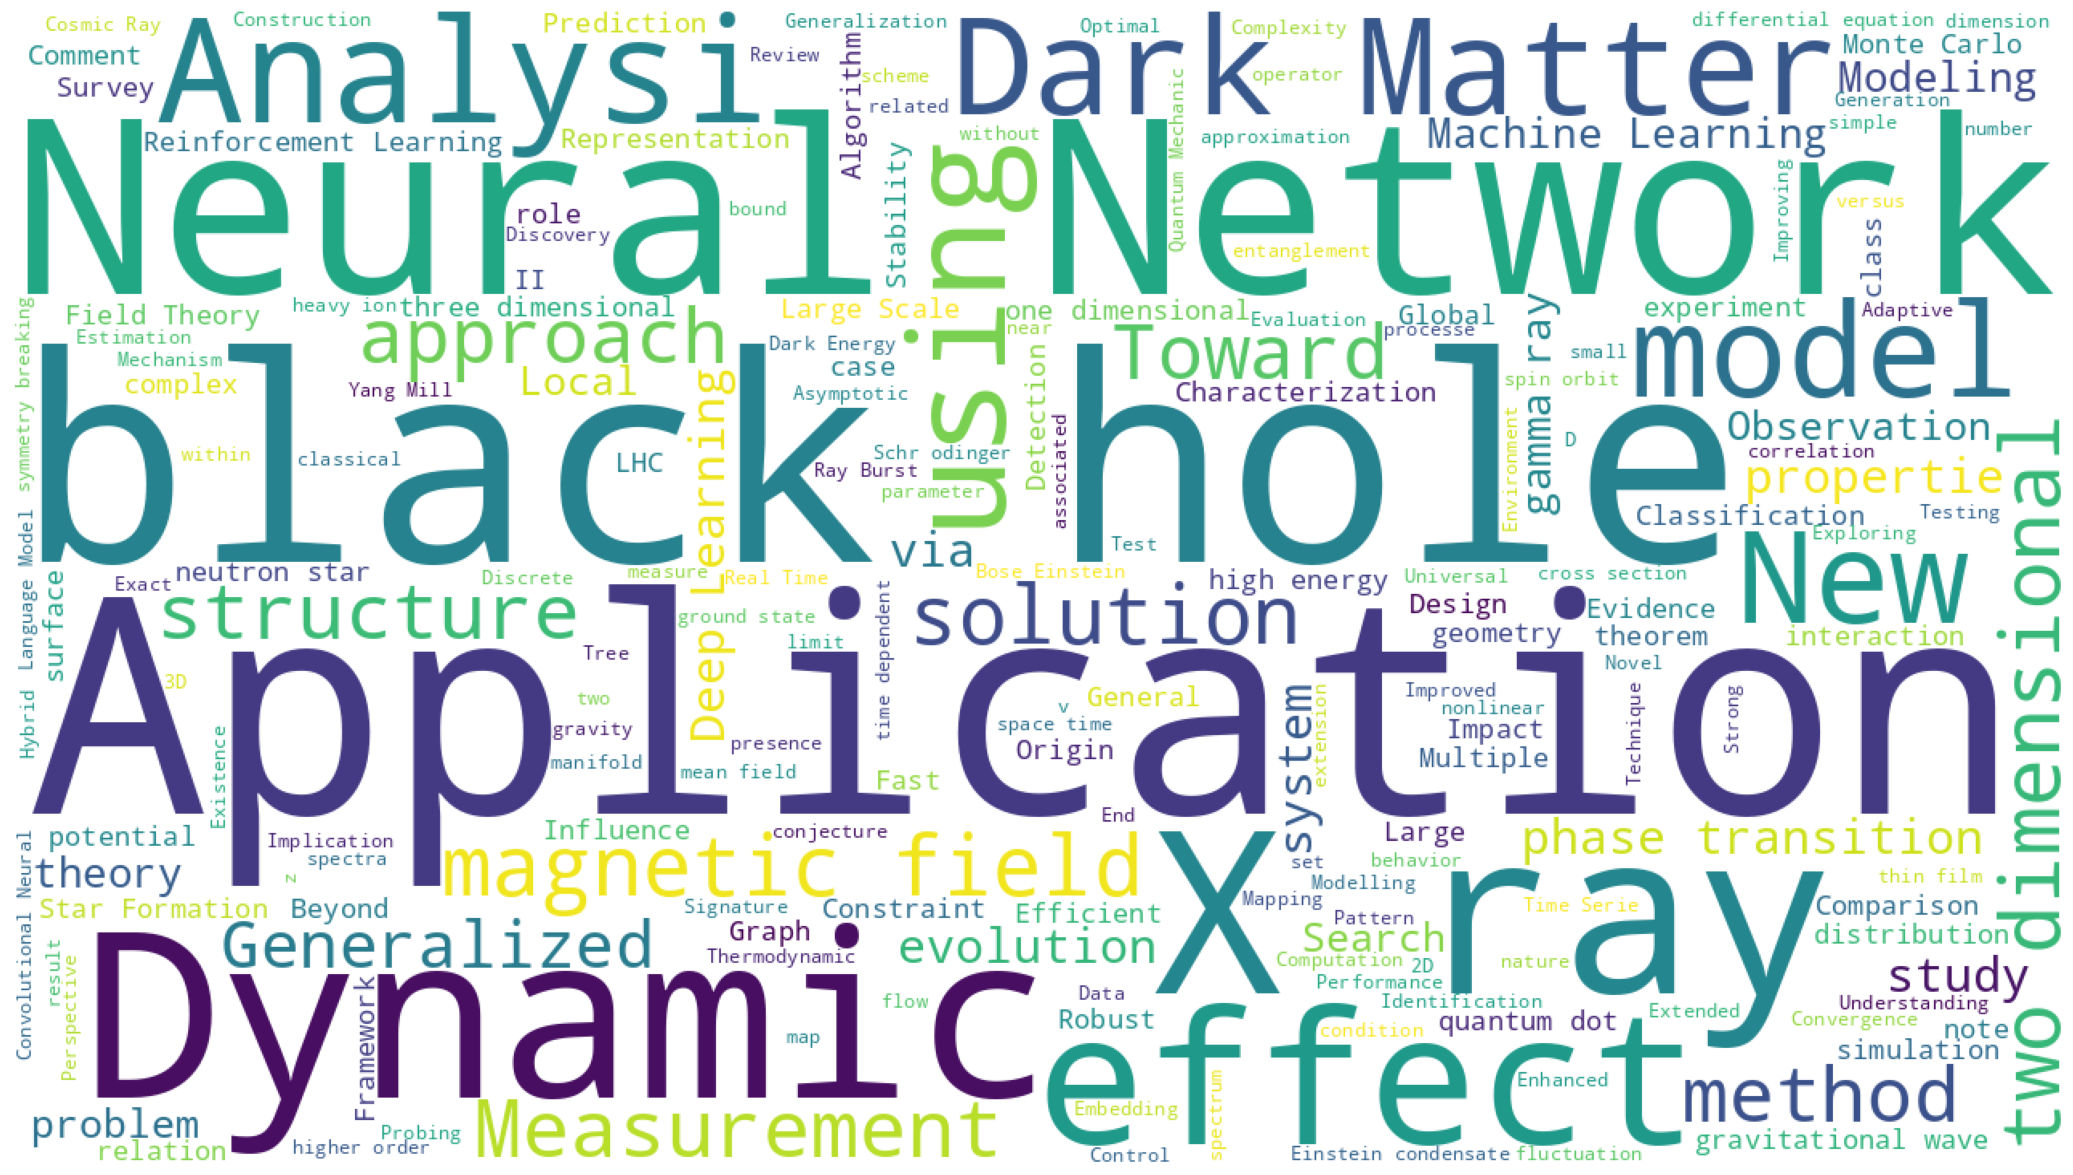

In [6]:
# Creating a word cloud of the topics present in the dataset using the title
# The complete dataset of 2+ million rows is used to create the word cloud
client.restart()
titles = df['title'].str.cat(sep=' ').compute()

# Plotting the figure using wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=1280, height=720, background_color='white').generate(titles)
plt.figure(figsize=(30, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

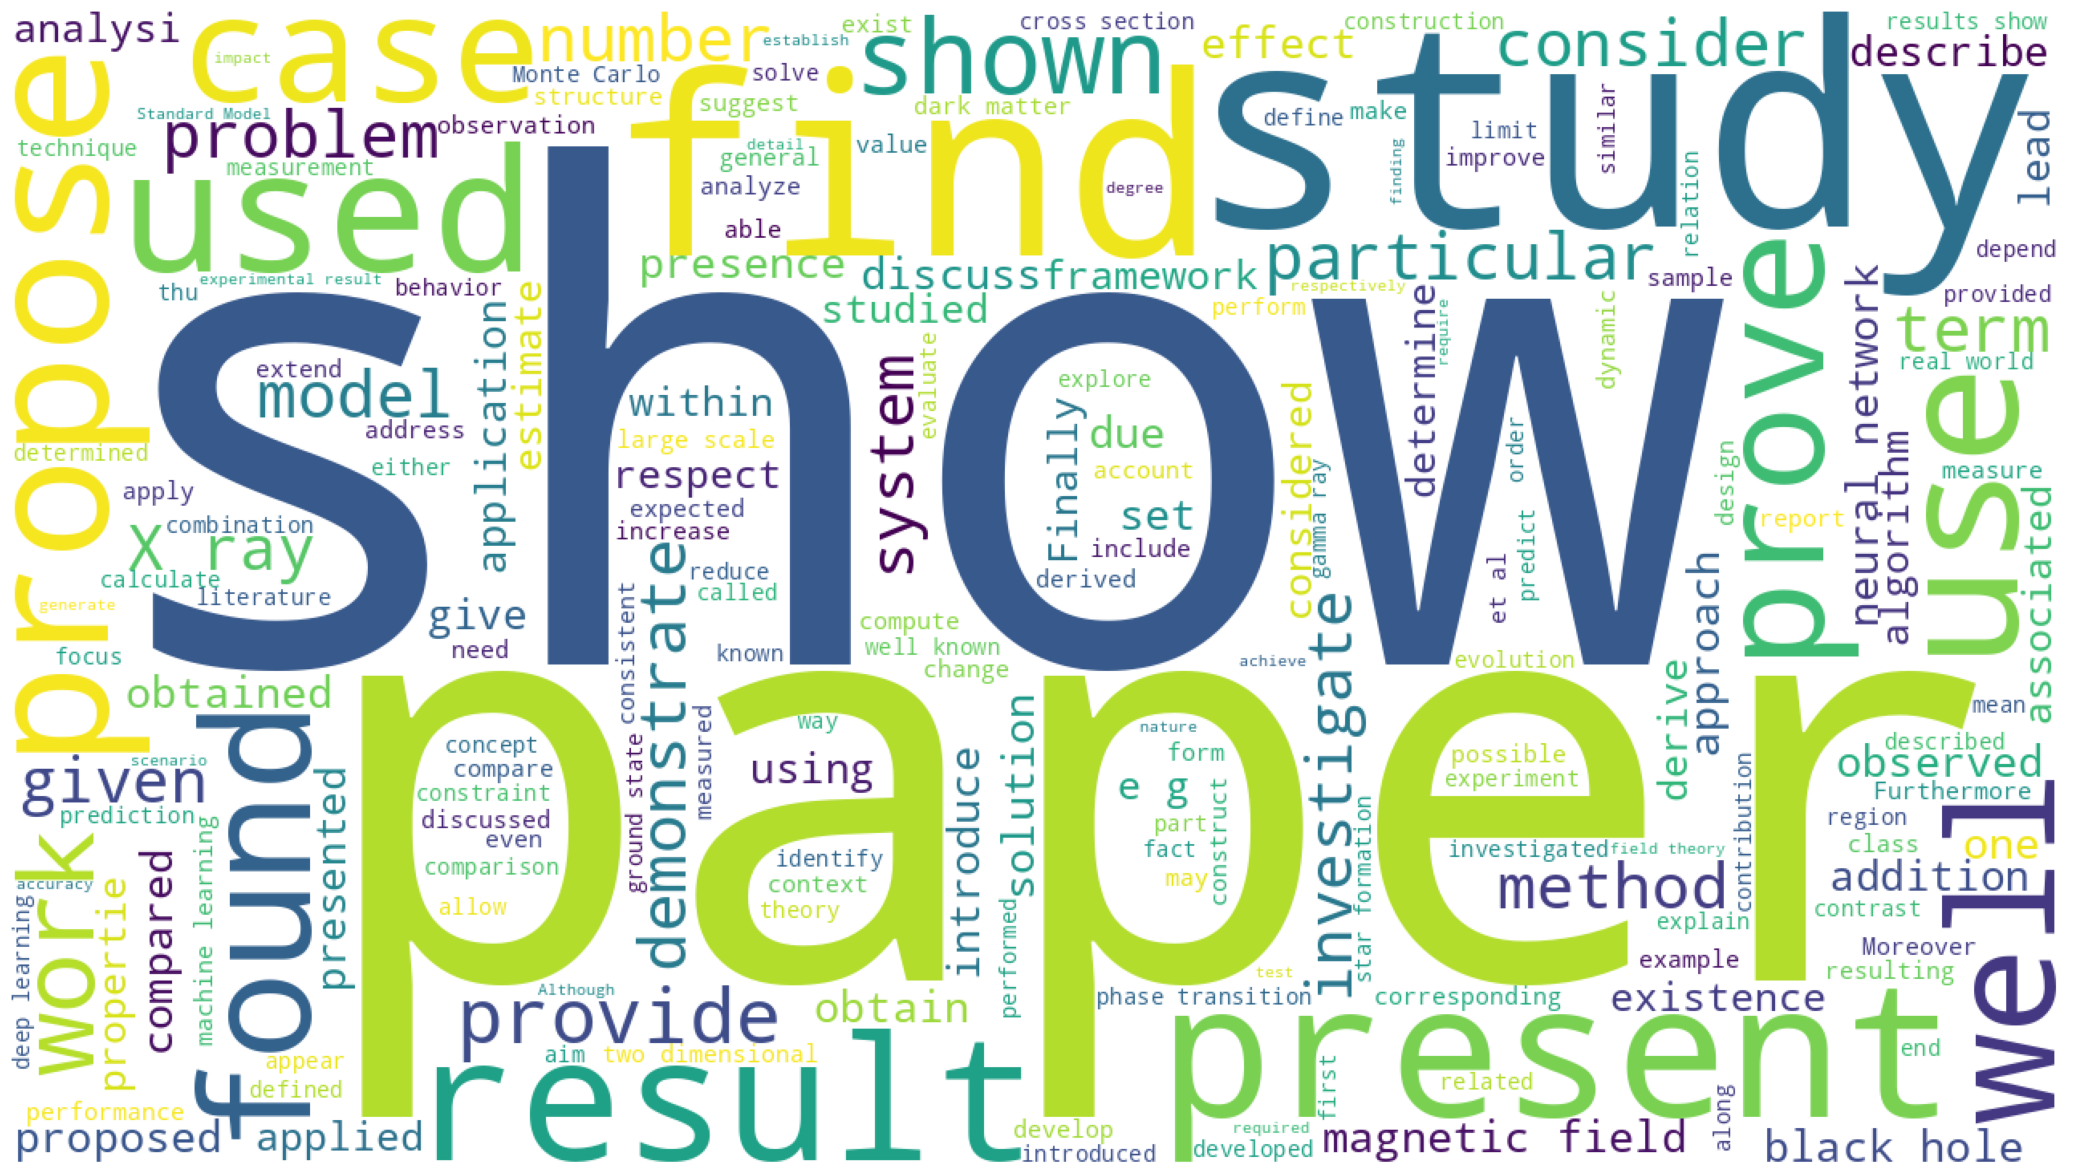

In [7]:
# Creating a word cloud of the topics present in the dataset using the abstract
# The complete dataset of 2+ million rows is used to create the word cloud
client.restart()
abstracts = df['abstract'].str.cat(sep=' ').compute()

# Plotting the figure using wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=1280, height=720, background_color='white').generate(abstracts)
plt.figure(figsize=(30, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()